In [1]:
from array import array
import itertools
import time
import math

import sys
#####For NERSC:####
#sys.path.insert(0,'/usr/common/software/rootpy/')
import root_numpy
import numpy as np

import matplotlib
import matplotlib.pyplot as plt

#import astroML.plotting as aml
#import iminuit
import pandas as pd
import root_pandas as rpd
from root_pandas import read_root
import ROOT
from ROOT import TH1D
from ROOT import SetOwnership
from matplotlib.ticker import NullFormatter
from ROOT import TLatex
%matplotlib inline                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                         

Welcome to ROOTaaS 6.06/06


In [2]:
Shower = "NN"
#Shower = "LO"
CorrectedP = True     #FALSE FOR HARDPROBES

if (Shower == "NN"):
    pPb_File = 'InputData/13def_SE_GMB_new_Ratio.root'
    pp_File = 'InputData/17q_SE_NN_Correlation_GMB_Ratio.root'
    if (CorrectedP):
        purity = 0.2615
    else:
        purity = 0.352546
if (Shower == "LO"):
    pPb_File = 'InputData/13def_SE_L0_Correlation_GMB_Ratio.root'
    pp_File = 'InputData/17q_SE_L0_Correlation_GMB_Ratio.root'
    if (CorrectedP):
        purity = 0.221083
    else:
        purity = 0.271083
        
print purity

pPb_File = 'InputData/13d_MB_0GeV_NN_15_20.root'
pp_File = 'InputData/17q_MB_0Gev_NN_15_20.root'
        
#pPb_File = 'InputData/13def_EMax_SE_GMB_Ratio.root'
#pp_File = 'InputData/17q_SE_EMax_Correlation_GMB_Ratio.root'

MC_File = 'InputData/18b10a_pthat_1_2_SE_NN_Correlation_GMB_Ratio.root'

0.2615


In [3]:
#delta_phi_centers= np.array([0.19634954084936207, 0.5890486225480862, 0.9817477042468103, 1.3744467859455345, 1.7671458676442586, 2.1598449493429825, 2.552544031041707, 2.945243112740431])

####Ommiting first dphi bin######
delta_phi_centers= np.array([0.5890486225480862, 0.9817477042468103, 1.3744467859455345, 1.7671458676442586, 2.1598449493429825, 2.552544031041707, 2.945243112740431])
phi_width = [0.39269908169872414/2]*len(delta_phi_centers)

###Array used for UE Error bar####
ue_error_bar = np.array([0,0.05,0.1,0.15,0.2,0.25,0.3,0.39269908169872414,2*0.39269908169872414])

zTbins = [0.05, 0.07670637, 0.11767734, 0.18053204, 0.27695915, 0.42489062, 0.65183634, 1]
pTbins = [0,0,15, 20]

#####. Total Number of zT bins, max 7  #####
NzT = 4

#####  Skip First N zT bins  #####
zT_offset = 2

zT_centers = np.zeros(NzT)
zT_widths = np.zeros(NzT)
for ztbin in range(zT_offset,NzT+zT_offset):
    zT_centers[ztbin-zT_offset] = (zTbins[ztbin]+ zTbins[ztbin+1])/2
    zT_widths[ztbin-zT_offset] = (zTbins[ztbin+1]-zTbins[ztbin])/2

Corrections = [1,1.007,0.982,0.970,0.942,0.830,0.640]
oneminFake = [1,0.982,0.980,0.978,0.970,0.915,0.812]

In [4]:
def Get_NTriggers(filename,ipt, Signal_DNN=True): 
    file = ROOT.TFile(filename)
    if (Signal_DNN == "Inclusive"):
        ntrig_histo = file.Get('N_Triggers_pT%1.0f_%1.0f' %(pTbins[ipt],pTbins[ipt+1]))
    else:
        DNN_Rgn = int(Signal_DNN) + 2*(1-int(Signal_DNN))
        ntrig_histo = file.Get('N_DNN%i_Triggers_pT%1.0f_%1.0f' %(DNN_Rgn,pTbins[ipt],pTbins[ipt+1]))
    NTriggers = 1
    if not(ntrig_histo == None):
        NTriggers = ntrig_histo.GetEntries()
    file.Close()
    return NTriggers

In [5]:
def GetEtaProj(filename,prfx,ipt, izt, Signal_DNN=True):
    
    file = ROOT.TFile(filename)

    N_Eta_Bins = 14
    
    if (Signal_DNN == "Inclusive"):
        histo2D = file.Get('Correlation__pT%1.0f_%1.0f__zT%1.0f_zT%1.0f' 
                        %(pTbins[ipt],pTbins[ipt+1],100*zTbins[izt],100*zTbins[izt+1]))
        
        Eta_Axis = histo2D.GetYaxis()
        EtaProjection = histo2D.ProjectionY('Inclusive_EtaProjection__pT_%1.0f_%1.0f__zt_%1.0f_%1.0f' 
                                      %(pTbins[ipt],pTbins[ipt+1],100*zTbins[izt],
                                        100*zTbins[izt+1]),0,-1)
    
    else:
        DNN_Rgn = int(Signal_DNN) + 2*(1-int(Signal_DNN)) #convert bool to DNN_1 (Sgn) or DNN_2 (Bkgd)
        histo2D = file.Get('DNN%i_Correlation__pT%1.0f_%1.0f__zT%1.0f_zT%1.0f' 
                            %(DNN_Rgn,pTbins[ipt],pTbins[ipt+1],100*zTbins[izt],100*zTbins[izt+1]))
        
        Eta_Axis = histo2D.GetYaxis()
        EtaProjection = histo2D.ProjectionY('DNN%i_EtaProjection__pT_%1.0f_%1.0f__zt_%1.0f_%1.0f' 
                                      %(DNN_Rgn,pTbins[ipt],pTbins[ipt+1],100*zTbins[izt],
                                        100*zTbins[izt+1]),0,-1)
    
    EtaProjection.SetDirectory(0)
    #EtaProjection.Scale(1.0/1.2)
    
    #per trigger yield
    ntriggers = Get_NTriggers(filename,ipt, Signal_DNN)
    if not(ntriggers == None):
        EtaProjection.Scale(1.0/ntriggers)
    
    file.Close()
    
    return EtaProjection

Info in <TCanvas::Print>: png file pics/Eta_Same_Mix_Projections_Trigger_pt_2.png has been created


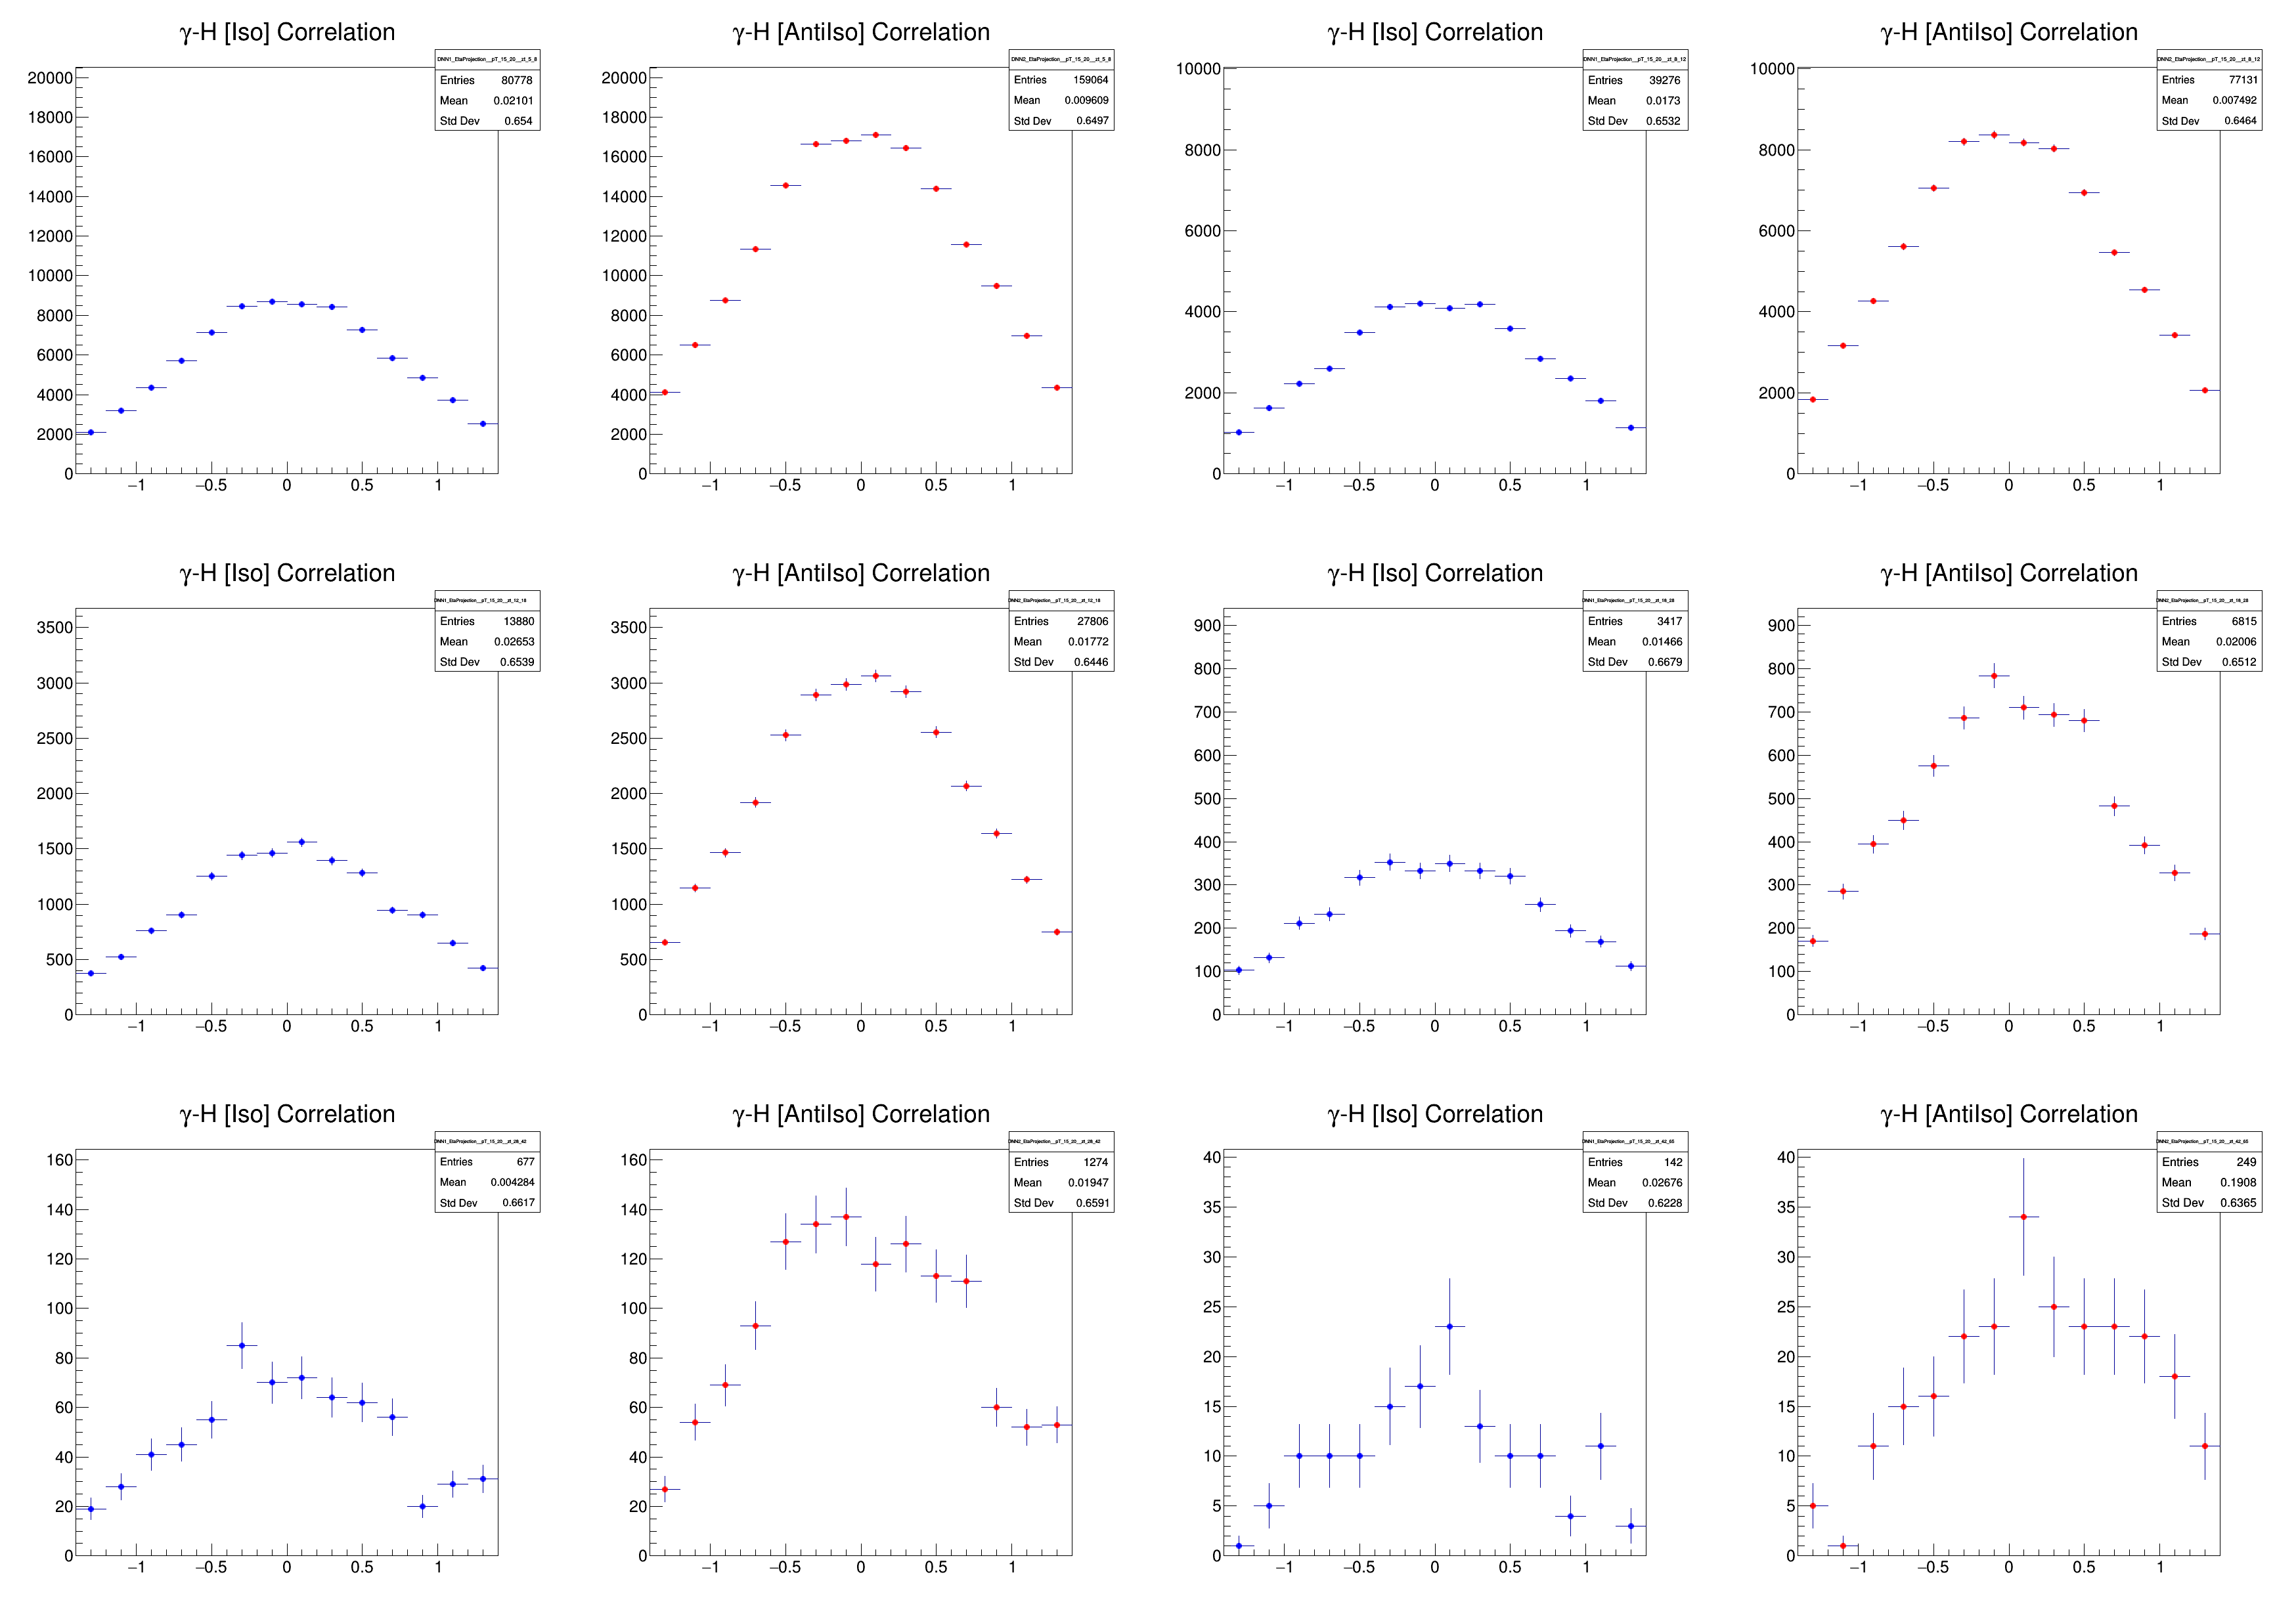

In [6]:
for ptbin in range(3):
    if(ptbin > 0): continue
    ptbin = ptbin+2
    canvases = ROOT.TCanvas("canv_phi","canv_phi",3500,2500)
    canvases.Divide(4,3)
    
    for ztbin in range(6):
    
        #grab
        hsig = GetEtaProj(pp_File,"pp",ptbin,ztbin,True) #no subtraction, change DNN
        hbkg = GetEtaProj(pp_File,"pp",ptbin,ztbin,False)
 
        #same scale
        ymax = 1.2*max(hsig.GetMaximum(),hbkg.GetMaximum())
        hsig.GetYaxis().SetRangeUser(0,ymax)
        hbkg.GetYaxis().SetRangeUser(0,ymax)    
    
        #Signal
        canvases.cd(ztbin*2+1)
        hsig.SetMarkerStyle(15)
        #hsig.SetMarkerSize(4)
        hsig.SetMarkerColor(4)
        hsig.Draw()
        
        #Background
        canvases.cd(ztbin*2+2)
        hbkg.SetMarkerStyle(15)
        #hbkg.SetMarkerSize(4)
        hbkg.SetMarkerColor(2)
        hbkg.Draw()
        #legend.AddEntry(hbkg,"Low DNN","l")
        #legend.Draw("same")
    
    canvases.Draw()   
    canvases.SaveAs("pics/Eta_Same_Mix_Projections_Trigger_pt_%i.png"%(ptbin))

# Numbers of Pairs in zT bins

In [7]:
Shower = "NN"
Low_pT_Files = ['InputData/17q_SE_NN_Correlation_GMB_Ratio.root','InputData/13def_SE_GMB_new_Ratio.root']
Low_pT_Bins = [12,15]
High_pT_Files = ['InputData/17q_SE_NN_Correlatios_GMB_Ratio_HighpT.root','InputData/13def_SE_NN_Correlatios_GMB_Ratio_HighpT.root']
High_pT_Bins = [15,20]

zTbins = [0.05, 0.07670637, 0.11767734, 0.18053204, 0.27695915, 0.42489062, 0.65183634, 1]
#####. Total Number of zT bins, max 7  #####
NzT = 4
#####  Skip First N zT bins  #####
zT_offset = 2


In [8]:
def GetCorrelation_Npairs(filename,pt_min,pt_max, izt, Signal_DNN=True):
    
    file = ROOT.TFile(filename)
    
    if (Signal_DNN == "Inclusive"):
        histo2D = file.Get('Correlation__pT%1.0f_%1.0f__zT%1.0f_zT%1.0f' 
                        %(pt_min[ipt],pt_max,100*zTbins[izt],100*zTbins[izt+1]))
    
    else:
        DNN_Rgn = int(Signal_DNN) + 2*(1-int(Signal_DNN)) #convert bool to DNN_1 (Sgn) or DNN_2 (Bkgd)
        
        histo2D = file.Get('DNN%i_Correlation__pT%1.0f_%1.0f__zT%1.0f_zT%1.0f' 
                            %(DNN_Rgn,pt_min,pt_max,100*zTbins[izt],100*zTbins[izt+1]))
        
    N_Pairs = histo2D.GetEntries()
    return N_Pairs

In [9]:
GetCorrelation_Npairs(High_pT_Files[0],High_pT_Bins[0],High_pT_Bins[1],2,True)

2089.2822588654376

In [10]:
low_pp = []
high_pp = []
low_pPb = []
high_pPb = []
ztstring = []
for izt in range (zT_offset,NzT+zT_offset):
    ztb = izt-zT_offset
    ztstring.append("%1.2f-%1.2f"%(zTbins[izt],zTbins[izt+1]))
    low_pp.append(GetCorrelation_Npairs('InputData/17q_SE_NN_Correlation.root',12,15,izt,True))
    high_pp.append(GetCorrelation_Npairs('InputData/17q_SE_NN_Correlation_HighpT.root',15,20,izt,True))
    low_pPb.append(GetCorrelation_Npairs('InputData/13def_SE_NN_Correlation.root',12,15,izt,True))
    high_pPb.append(GetCorrelation_Npairs('InputData/13def_SE_NN_Correlation_HighpT.root',15,20,izt,True))

print(ztstring)
print(low_pp)
print(high_pp)
print(low_pPb)
print(high_pPb)

AttributeError: 'TObject' object has no attribute 'GetEntries'

# Look at simple $\Delta \phi$ Projections

In [ ]:
# pPb_File = 'InputData/13d_MB_0GeV_NN_15_20.root'
# pp_File = 'InputData/17q_MB_0Gev_NN_15_20.root'

In [ ]:
#####Obtains the phi projection within the eta region (|eta|<0.6)#####
def GetPhiProj(filename,prfx,ipt, izt, Signal_DNN=True):
    
    file = ROOT.TFile(filename)

    eta_max = 1.2 #Assuming symmetric eta range
    
    if (Signal_DNN == "Inclusive"):
        histo2D = file.Get('Correlation__pT%1.0f_%1.0f__zT%1.0f_zT%1.0f' 
                        %(pTbins[ipt],pTbins[ipt+1],100*zTbins[izt],100*zTbins[izt+1]))
        
        Eta_Axis = histo2D.GetYaxis()
        PhiProjection = histo2D.ProjectionX('Inclusive_PhiProjection__pT_%1.0f_%1.0f__zt_%1.0f_%1.0f' 
                                      %(pTbins[ipt],pTbins[ipt+1],100*zTbins[izt],
                                        100*zTbins[izt+1]),Eta_Axis.FindBin(-eta_max),Eta_Axis.FindBin(eta_max))
    
    else:
        DNN_Rgn = int(Signal_DNN) + 2*(1-int(Signal_DNN)) #convert bool to DNN_1 (Sgn) or DNN_2 (Bkgd)
        histo2D = file.Get('DNN%i_Correlation__pT%1.0f_%1.0f__zT%1.0f_zT%1.0f' 
                            %(DNN_Rgn,pTbins[ipt],pTbins[ipt+1],100*zTbins[izt],100*zTbins[izt+1]))
        
        Eta_Axis = histo2D.GetYaxis()
        PhiProjection = histo2D.ProjectionX('DNN%i_PhiProjection__pT_%1.0f_%1.0f__zt_%1.0f_%1.0f' 
                                      %(DNN_Rgn,pTbins[ipt],pTbins[ipt+1],100*zTbins[izt],
                                        100*zTbins[izt+1]),Eta_Axis.FindBin(-eta_max),Eta_Axis.FindBin(eta_max))
                                            
    PhiProjection.SetDirectory(0)
    PhiProjection.Rebin(2)
    PhiProjection.Scale(1.0/(2*eta_max))
    
    #per trigger yield
#     ntriggers = Get_NTriggers(filename,ipt, Signal_DNN)
#     if not(ntriggers == None):
#         PhiProjection.Scale(1.0/ntriggers)
    
    file.Close()
    
    Phi_Array = np.zeros(len(delta_phi_centers))
    Phi_Error_Array = np.zeros(len(delta_phi_centers))
    for bin in range(2,9):
        Phi_Array[bin-2] = PhiProjection.GetBinContent(bin)
        Phi_Error_Array[bin-2] = PhiProjection.GetBinError(bin)
    
    return Phi_Array, Phi_Error_Array

In [ ]:
Systems = ["pp","p-Pb"]
Files = [pp_File,pPb_File]

for sys,ifile in zip(Systems,Files):
    fig = plt.figure(figsize=(34,17))
    for ipt in range (3):
        if (ipt > 0): continue
        ipt = ipt+2
        for izt in range (zT_offset,NzT+zT_offset):
            
            ztb = izt-zT_offset

            Sig_Phi_Array, Sig_Phi_Error_Array = GetPhiProj(ifile,sys,ipt,izt,True)
            Bkg_Phi_Array, Bkg_Phi_Error_Array = GetPhiProj(ifile,sys,ipt,izt,False)
                                            
                                        #--------------plot--------------------#
           
            if (NzT ==4):
                ax = fig.add_subplot(2,4,(2*ztb+1))
            elif (NzT ==6):
                ax = fig.add_subplot(3,4,(2*ztb+1))
                
            fsize = 20

            #sig
            ax.plot(delta_phi_centers,Sig_Phi_Array,'bo',ms=10)
            s_plot = ax.errorbar(delta_phi_centers,Sig_Phi_Array,xerr=phi_width,yerr=Sig_Phi_Error_Array,
                                 fmt=None,ecolor='b',label='Signal Region (stat. error)')

            plt.xlabel(r'|$\Delta \varphi$|',fontsize=fsize+4)
            plt.xticks(fontsize=(fsize))
            plt.xlim((0.39269908169872414,3.14159))
            plt.ylabel(r'$1/N_{\mathrm{trig}} \: \: \mathrm{d}N/\mathrm{d}\Delta\eta$',fontsize=fsize+2)
            plt.ylim((0,1.2*max(Sig_Phi_Array)))
            empt, = ax.plot([], [], ' ')
            empt2, = ax.plot([],[],' ')
            plt.yticks(fontsize=fsize-5)

            fill_x = [0,3.14159]
#             s_z_line = ax.fill_between(fill_x, Sig_Z_Value-Sig_Z_Error,Sig_Z_Value+Sig_Z_Error,interpolate=False,edgecolor='cyan',linewidth=0.0, alpha=0.3,facecolor='cyan')
#             s_le_line = ax.fill_between(fill_x, S_LE-S_LE_Error,S_LE+S_LE_Error,interpolate=False,edgecolor='grey',linewidth=0.0, alpha=0.5,facecolor='grey')

            leg = ax.legend([s_plot,empt,empt2],['Signal Region (stat. error)','0.8 <|$\Delta\eta$| < 1.4',
                'UE Estimate',r'%1.2f < $z_\mathrm{T}$ < %1.2f'%(zTbins[izt],zTbins[izt+1]),
                r'15 < $p_\mathrm{T}^{\mathrm{trig}}$ < 20 GeV/$c$'],loc='best',
                title = "Alice Preliminary 5 TeV %s"%(sys),fontsize=14,frameon=False,numpoints=1)
            plt.setp(leg.get_title(),fontsize=20)
#             if (sys == 'pp'):
#                 leg.set_title("ALICE Preliminary, $\sqrt{s}=$5 TeV %s"%(sys))
#             else:
#                 leg.set_title("ALICE Preliminary, $\sqrt{s_{\mathrm{_{NN}}}}=$5 TeV %s"%(sys))                
#             plt.setp(leg.get_title(),fontsize=14)


            #bkg
            if (NzT ==4):
                ax = fig.add_subplot(2,4,(2*ztb+2))
            elif (NzT ==6):
                ax = fig.add_subplot(3,4,(2*ztb+2))
                
            #ax = fig.add_subplot(1,2,1)
            plt.xlabel(r'|$\Delta \varphi$|',fontsize=fsize+4)
            plt.xticks(fontsize=(fsize))
            plt.xlim((0.39269908169872414,3.14159))
            plt.ylabel(r'$1/N_{\mathrm{trig}} \: \: \mathrm{d}N/\mathrm{d}\Delta\eta$',fontsize=fsize+2)
            plt.ylim((0,1.2*max(Bkg_Phi_Array)))
            plt.yticks(fontsize=fsize-5)

            fill_x = [0,3.14149]
#             b_z_line = plt.fill_between(fill_x, Bkg_Z_Value-Bkg_Z_Error,Bkg_Z_Value+Bkg_Z_Error,interpolate=False,edgecolor='cyan',linewidth=0.0, alpha=0.3,facecolor='cyan')
#             b_le_line = plt.fill_between(fill_x, Bkg_LE-Bkg_LE_Error,Bkg_LE+Bkg_LE_Error,interpolate=False,edgecolor='grey',linewidth=0.0, alpha=0.5,facecolor='grey')

            ax.plot(delta_phi_centers,Bkg_Phi_Array,'ro',ms=10)
            b_plot = ax.errorbar(delta_phi_centers,Bkg_Phi_Array,xerr=phi_width,yerr=Bkg_Phi_Error_Array,fmt=None,ecolor='r')

            leg = ax.legend([b_plot,empt,empt2],['Bkg Region (stat. error)',r'%1.2f < $z_\mathrm{T}$ < %1.2f'%(zTbins[izt],
                zTbins[izt+1]),r'15 < $p_\mathrm{T}^{\mathrm{trig}}$ < 20 GeV/$c$'],loc='best',
                title = "Alice Preliminary 5 TeV %s"%(sys),fontsize=14,frameon=False,numpoints=1)
            plt.setp(leg.get_title(),fontsize=20)

     
    print("")
    #return



In [ ]:
print(pTbins[2])

10286.0
18520.0
28


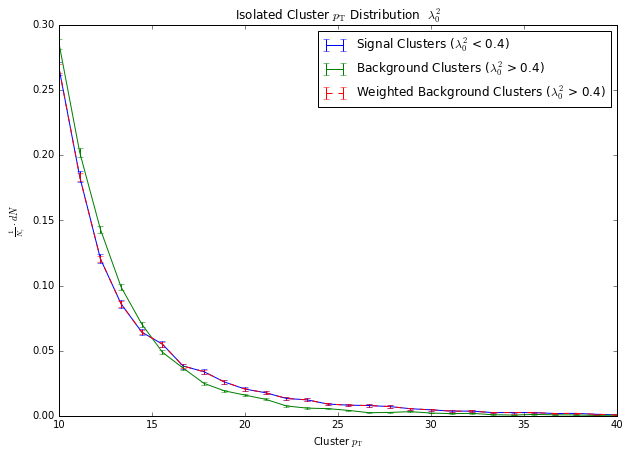

In [17]:
#Shower_Shape = "NN"
Shower_Shape = "L0"

if (Shower_Shape=="NN"):
    File = 'InputData/17q_SE_NN_Correlation.root'
elif (Shower_Shape=="L0"):
    File = 'InputData/13d_SE_L0_Correlation.root'
file = ROOT.TFile(File)

N_Sig_histo = file.Get("N_DNN1_Triggers_pT12_15")
N_Sig = N_Sig_histo.GetEntries()
N_BKG_histo = file.Get("N_DNN2_Triggers_pT12_15")
N_BKG = N_BKG_histo.GetEntries()


SIG = file.Get("Signal_pT_Dist")
print(SIG.GetEntries())
BKGD = file.Get("BKGD_pT_Dist")
print(BKGD.GetEntries())
BKGD_W = file.Get("BKGD_pT_Dist_Weighted")

#SIG.Rebin(10)
Signal = root_numpy.hist2array(SIG)
S_Scale = Signal.sum(axis=0)
Signal = Signal/S_Scale


#BKGD.Rebin(10)
Background = root_numpy.hist2array(BKGD)
B_Scale = Background.sum(axis=0)
Background = Background/B_Scale

#BKGD_W.Rebin(10)
Background_W = root_numpy.hist2array(BKGD_W)
B_Scale_W = Background_W.sum(axis=0)
Background_W = Background_W/B_Scale_W

N_Bins = SIG.GetSize() - 2 #Ignero under/overflow

S_Error = np.zeros(N_Bins)
B_Error = np.zeros(N_Bins)
BW_Error = np.zeros(N_Bins)
for i in range(1,N_Bins+1):
    S_Error[i-1] = SIG.GetBinError(i)
    B_Error[i-1] = BKGD.GetBinError(i)
    BW_Error[i-1] = BKGD_W.GetBinError(i)
    
S_Error = S_Error/S_Scale
B_Error = B_Error/B_Scale
BW_Error = BW_Error/B_Scale_W
    
print(Signal.size)

pT_Axis = np.linspace(10,40,N_Bins)

fig = plt.figure(figsize=(10,7))
if (Shower_Shape=="NN"):
    plt.plot(pT_Axis,Signal,label="Signal Clusters ($0.5 < NN < 0.85)")
    plt.plot(pT_Axis,Background,label="Background Clusters ($NN < 0.55$)")
    plt.title(r"Isolated Cluster $p_{\mathrm{T}}$ Distribution  $DNN$")

elif (Shower_Shape=="L0"):
    plt.errorbar(pT_Axis,Signal,yerr = S_Error,label="Signal Clusters ($\lambda^{2}_{0}$ < 0.4)")
    plt.errorbar(pT_Axis,Background,yerr = B_Error,label="Background Clusters ($\lambda^{2}_{0}$ > 0.4)")
    plt.errorbar(pT_Axis,Background_W,yerr = BW_Error,fmt = "--r",label="Weighted Background Clusters ($\lambda^{2}_{0}$ > 0.4)")
    plt.title(r"Isolated Cluster $p_{\mathrm{T}}$ Distribution  $\lambda^{2}_{0}$")
    #plt.ylim(0,0.01)
    
plt.xlabel(r'Cluster $p_{\mathrm{T}}$')
plt.ylabel(r'$\frac{1}{N_{\gamma}}\cdot dN$')
plt.legend()
fig.savefig('pics/Cluster_pT_Weighted.pdf', bbox_inches='tight')



<ROOT.TH1F object ("hweight") at 0x7653f20>
221.901939026


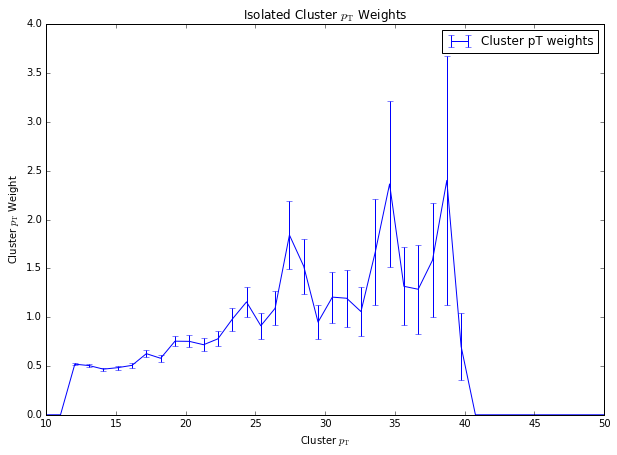

In [4]:
#Shower_Shape = "NN"
Shower_Shape = "L0"

if (Shower_Shape=="NN"):
    File = 'InputData/17q_SE_NN_Correlation.root'
elif (Shower_Shape=="L0"):
    File = 'InputData/13d_SE_L0_Correlation.root'
file = ROOT.TFile(File)

SIG = file.Get("hweight")
print(SIG)
print(SIG.GetEntries())
Signal = root_numpy.hist2array(SIG)
S_Error = np.zeros(40)
for i in range(1,41):
    S_Error[i-1] = SIG.GetBinError(i)
    

pT_Axis = np.linspace(10,50,40)
fig = plt.figure(figsize=(10,7))

if (Shower_Shape=="NN"):
    plt.errorbar(pT_Axis,Signal,yerr = S_Error,label="Signal Clusters ($0.5 < NN < 0.85)")
    
elif (Shower_Shape=="L0"):
    plt.errorbar(pT_Axis,Signal,yerr = S_Error,label="Cluster pT weights")
    plt.title(r"Isolated Cluster $p_{\mathrm{T}}$ Weights")

    
plt.xlabel(r'Cluster $p_{\mathrm{T}}$')
plt.ylabel(r'Cluster $p_{\mathrm{T}}$ Weight')
#plt.ylim(0,1.2)
plt.legend()
fig.savefig('pics/Weights.pdf', bbox_inches='tight')


